<a href="https://colab.research.google.com/github/fbkaragoz/notebooks/blob/main/eksi_eda_30_10_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turkish NLP Pipeline – Rework Summary & New Plan

## Previous Insight (Brief):
I identified that `TfidfVectorizer` with n-grams splits meaningful Turkish idioms/collocations into overlapping fragments, causing noise, double-counting, and semantic loss. Solution: **merge phrases into single tokens before vectorization**.

See the full notebook here: [eksi_eda_29_10_2025.ipynb](https://github.com/fbkaragoz/notebooks/blob/main/eksi_eda_29_10_2025.ipynb)

---

## Our New, Improved Plan

1. **Load Data**: Use the 600k-entry dataset.  
2. **Initial Cleaning** (durak-nlp): Remove HTML (http, www), punctuation; convert to lowercase.  
3. **Stopword Removal**: Strip all `BASE_STOPWORDS`.  
4. **Tokenize**: Split cleaned text into word lists.  
5. **Find Phrases**: Train `gensim.Phrases` on token lists to detect significant collocations.  
6. **Merge Phrases**: Transform text — e.g., `["etekleri", "zil", "çalıyordu"]` → `["etekleri_zil_çalıyordu"]`.  
7. **Run TF-IDF**: Join merged tokens into strings → apply `TfidfVectorizer`.

**Result**: Cleaner, semantically coherent features; no phrase fragmentation; better clustering.

In [3]:
%pip install durak-nlp==0.2.4

In [4]:
arc_path = '/content/drive/MyDrive/2 - work/2.9.0 — ekşifikir/eksi_v2.db.tar.gz'
!tar -xvf "$arc_path" -C .
dbp = '/content/eksi.db'


eksi.db


In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(dbp)

tables =\
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,topics
1,entries
2,references_map
3,sqlite_stat1


In [6]:
schema =\
pd.read_sql_query("PRAGMA table_info(entries);", conn)

schema

,cid,name,type,notnull,dflt_value,pk
0,0,entry_id,TEXT,0,None,1
1,1,topic_id,TEXT,0,None,0
2,2,title,TEXT,0,None,0
3,3,author_hash,TEXT,0,None,0
4,4,favorites,INTEGER,0,None,0
5,5,created_at_ts,TEXT,0,None,0
6,6,created_at_raw,TEXT,0,None,0
7,7,text_clean,TEXT,0,None,0
8,8,url,TEXT,0,None,0
9,9,text_hash,TEXT,0,None,0


In [7]:
entries = pd.read_sql_query("SELECT * FROM entries;", conn)

# Load all topics instead of a random sample
topics = pd.read_sql_query("SELECT * FROM topics;", conn)

references_map = pd.read_sql_query("SELECT * FROM references_map;", conn)

entries.head()

,entry_id,topic_id,title,author_hash,favorites,created_at_ts,created_at_raw,text_clean,url,text_hash,crawl_ts
0,179182040,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,a9e5be5a0082c6c31a6dc910e3352eac5672d202ef7fa1...,0,2025-10-17T17:26:00,17.10.2025 17:26,https://x.com/…rbandicom/status/19791015344419...,https://eksisozluk.com/3-yildir-evden-cikmayan...,2f60d585b3f53765b6ce9e14cdd6473fdad80fea4d3e61...,2025-10-17T16:01:02.648953
1,179182267,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,3a2f0017065ab43336760c8cecf4986bbaab10efd28209...,0,2025-10-17T17:38:00,17.10.2025 17:38,"benim anladığım, bizler sağlıklı düşünüp tembe...",https://eksisozluk.com/3-yildir-evden-cikmayan...,aea183a5e5191c327ab5fb9aa36f2a93059b615d7be9d2...,2025-10-17T16:01:02.648953
2,179182426,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,590c9da2bf0c11b2967d66749188f00d574cbb59208e51...,0,2025-10-17T17:46:00,17.10.2025 17:46,bu genci tedavi etmenin çok basit bir yolu var...,https://eksisozluk.com/3-yildir-evden-cikmayan...,960ace213db65b159822db252a5078a9a8d336ba07dc2d...,2025-10-17T16:01:02.648953
3,179182509,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,7c4768cab477b28f3d065b5b47184e821a9bca72b1f937...,0,2025-10-17T17:50:00,17.10.2025 17:50,çocuk derin bir depresyonda ve tek derdi tıraş...,https://eksisozluk.com/3-yildir-evden-cikmayan...,5f66285026d3f4f716591f823867a6fa5f9f9dd673e0a9...,2025-10-17T16:01:02.648953
4,179182510,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,0fc0161ae3cf08094f94e92c0ee794abaca1c5030acfd4...,0,2025-10-17T17:50:00,17.10.2025 17:50,allah'tan evden çıkmak istemiyormuş. es kaza s...,https://eksisozluk.com/3-yildir-evden-cikmayan...,60a88c82b18a0297c9dc0c60ba15c83d6ceb79851056d3...,2025-10-17T16:01:02.648953


In [8]:
from durak import process_text

# Apply preprocessing to the 'text_clean' column with suffix fixation
entries['text_processed'] = entries['text_clean'].apply(
    lambda x: ' '.join(process_text(x, remove_stopwords=True, rejoin_suffixes=True)) if isinstance(x, str) else ''
)

In [9]:
# Apply preprocessing to the 'title' column
entries['title_processed'] = entries['title'].apply(
    lambda x: ' '.join(process_text(x, remove_stopwords=True)) if isinstance(x, str) else ''
)


In [10]:
display(entries[['text_clean', 'text_processed', 'title', 'title_processed']].head())

,text_clean,text_processed,title,title_processed
0,https://x.com/…rbandicom/status/19791015344419...,yuce devletimizin olaya el atmasiyla cozulmus ...,3 yıldır evden çıkmayan gencin evden çıkarılması,3 yıldır evden çıkmayan gencin evden çıkarılması
1,"benim anladığım, bizler sağlıklı düşünüp tembe...","anladığım , bizler sağlıklı düşünüp tembellikl...",3 yıldır evden çıkmayan gencin evden çıkarılması,3 yıldır evden çıkmayan gencin evden çıkarılması
2,bu genci tedavi etmenin çok basit bir yolu var...,genci tedavi etmenin basit yolu . kendisini al...,3 yıldır evden çıkmayan gencin evden çıkarılması,3 yıldır evden çıkmayan gencin evden çıkarılması
3,çocuk derin bir depresyonda ve tek derdi tıraş...,çocuk derin depresyonda tek derdi tıraş olmama...,3 yıldır evden çıkmayan gencin evden çıkarılması,3 yıldır evden çıkmayan gencin evden çıkarılması
4,allah'tan evden çıkmak istemiyormuş. es kaza s...,allah'tan evden çıkmak istemiyormuş . es kaza ...,3 yıldır evden çıkmayan gencin evden çıkarılması,3 yıldır evden çıkmayan gencin evden çıkarılması


<Axes: title={'center': 'Aylık Entry Sayısı'}, xlabel='year_month'>

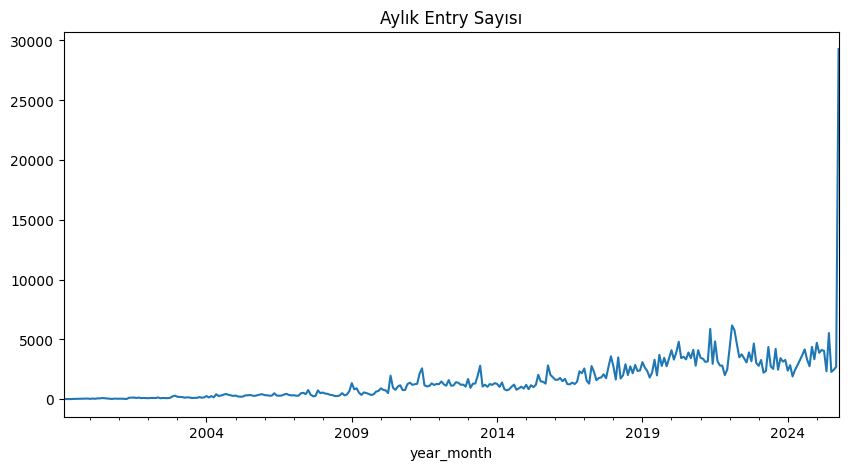

In [11]:
entries['created_at_ts'] =\
pd.to_datetime(entries['created_at_ts'], errors='coerce')

entries['year_month'] = entries['created_at_ts'].dt.to_period('M')
entries.groupby('year_month').size().plot(kind='line', figsize=(10,5), title='Aylık Entry Sayısı')

## Make the time-series cleaner

In [12]:
mo = entries.groupby('year_month').size()
qu = mo.resample('Q').sum()               # quarterly
roll = mo.rolling(12).mean()              # 12-mo moving average
gr = mo.pct_change()*100                  # growth rate


/tmp/ipython-input-2168081626.py:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  qu = mo.resample('Q').sum()               # quarterly


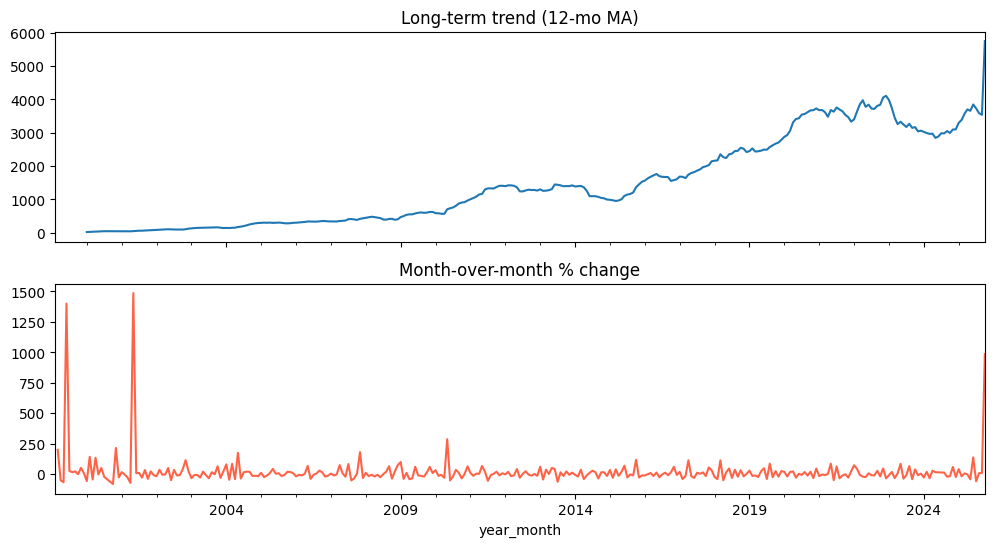

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
roll.plot(ax=ax[0], title='Long-term trend (12-mo MA)')
gr.plot(ax=ax[1], title='Month-over-month % change', color='tomato')
plt.show()

## Seasonality: "Which months are meme-season?"

/tmp/ipython-input-4202661309.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mo.index, y=mo.values, palette=colors)


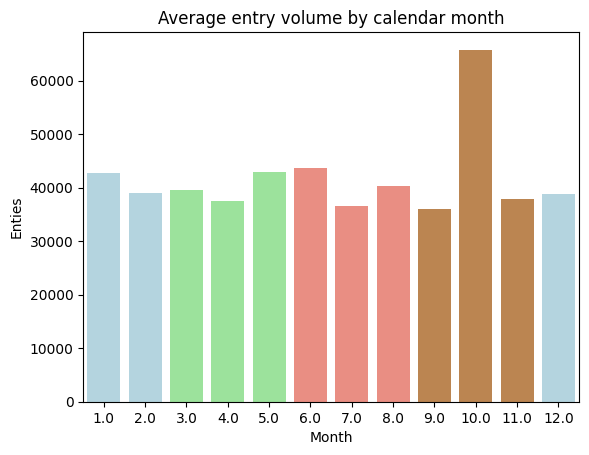

In [14]:
import seaborn as sns

seasonal_palette = {
    1: 'lightblue', 2: 'lightblue', 3: 'lightgreen', 4: 'lightgreen',
    5: 'lightgreen', 6: 'salmon', 7: 'salmon', 8: 'salmon',
    9: 'peru', 10: 'peru', 11: 'peru', 12: 'lightblue'
}

mo = entries.groupby(entries['created_at_ts'].dt.month).size().sort_index()

colors = [seasonal_palette[month] for month in mo.index]

sns.barplot(x=mo.index, y=mo.values, palette=colors)
plt.title('Average entry volume by calendar month')
plt.xlabel('Month'); plt.ylabel('Enties')
plt.show()

## Weekday vs Weekend: Are people more active on the job or after?


/tmp/ipython-input-3304084083.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='is_weekend',


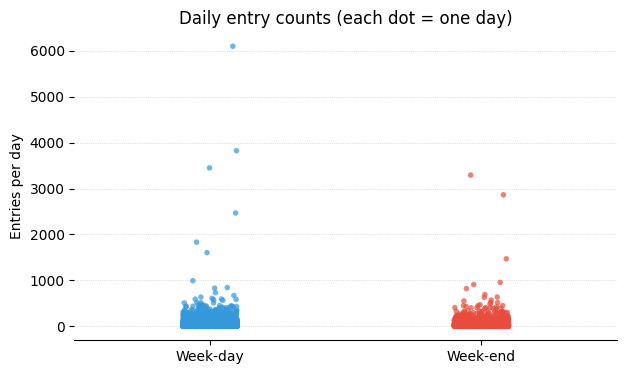

In [15]:
# ------------------------------------------------------------------
# 1. Build the daily aggregates once, give them readable names
# ------------------------------------------------------------------
daily_df = (entries
            .assign(date=entries['created_at_ts'].dt.date,
                    is_weekend=entries['created_at_ts'].dt.dayofweek >= 5)
            .groupby(['date', 'is_weekend'])
            .size()
            .reset_index(name='entries_per_day'))

# ------------------------------------------------------------------
# 2. Plot with readable labels and a reference grid
# ------------------------------------------------------------------
plt.figure(figsize=(7, 4))
sns.stripplot(x='is_weekend',
              y='entries_per_day',
              data=daily_df,
              palette=['#3498db','#e74c3c'],
              size=4,
              alpha=.7)

sns.despine(left=True)
plt.xlabel(None)
plt.xticks([0, 1], ['Week-day', 'Week-end'])
plt.ylabel('Entries per day')
plt.title('Daily entry counts (each dot = one day)')
plt.grid(axis='y', ls=':', lw=.5, alpha=.7)

## Topic life-cycle: which topics explode & die?


In [16]:
topic_month = (entries
               .groupby(['topic_id','year_month'])
               .size()
               .reset_index(name='n'))
display(topic_month.head())

,topic_id,year_month,n
0,1004129,2005-11,2
1,1004129,2006-11,1
2,1004129,2007-02,1
3,1004129,2007-11,3
4,1004129,2008-01,1


In [17]:
# Merge topic_month with the topics DataFrame to get topic titles
topic_month_with_titles = pd.merge(topic_month, topics[['topic_id', 'title']], on='topic_id', how='left')

# Display the result
display(topic_month_with_titles.head())

,topic_id,year_month,n,title
0,1004129,2005-11,2,yıldız silier
1,1004129,2006-11,1,yıldız silier
2,1004129,2007-02,1,yıldız silier
3,1004129,2007-11,3,yıldız silier
4,1004129,2008-01,1,yıldız silier


The previous cell grouped the data by `topic_id` and `year_month` and counted the number of entries for each group. The resulting dataframe `topic_month` has the following columns: `topic_id`, `year_month`, and `n` (number of entries).

## Who are the night-owls and who are the early-birds?

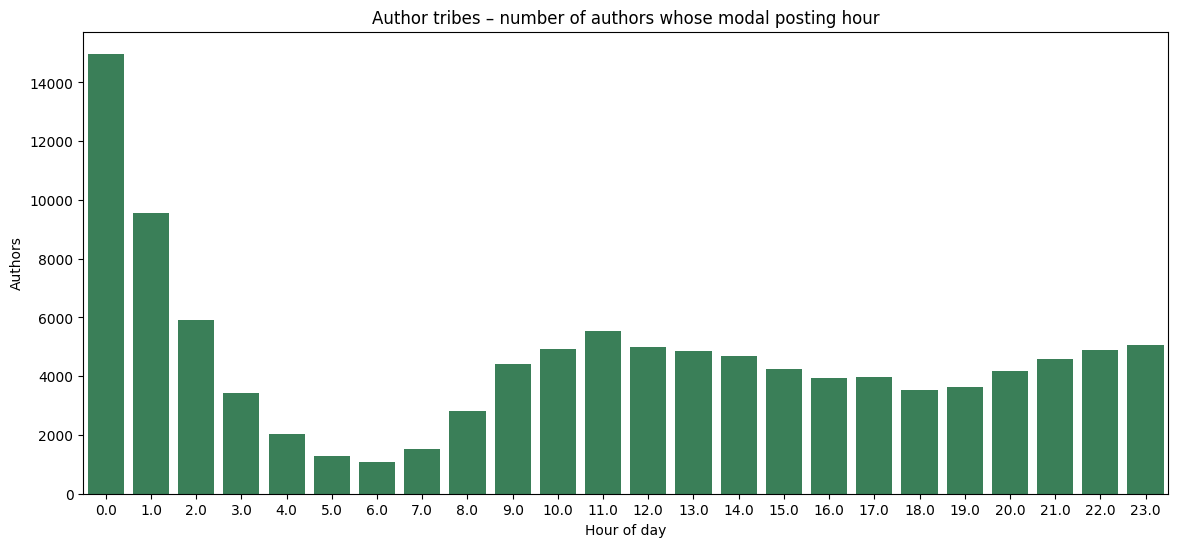

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the 'hour' column
entries['hour'] = pd.to_datetime(entries['created_at_ts']).dt.hour

author_hour = entries.groupby('author_hash')['hour'].agg(lambda s: s.mode()[0] if not s.mode().empty else None).reset_index()
tribe_sizes = author_hour['hour'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(14, 6)) # Increased figure size
sns.barplot(x=tribe_sizes.index, y=tribe_sizes.values, ax=ax, color='seagreen') # Added ax=ax
plt.title('Author tribes – number of authors whose modal posting hour')
plt.xlabel('Hour of day')
plt.ylabel('Authors')
plt.show()

What we just drew is not a bar chart of entry counts – it’s a **census of author personalities**.  
Every bar tells us how many **distinct authors** “live” in that hour.  

- The tallest skyscraper is at **hour 0 (midnight)** – **>12k authors** are midnight regulars.  
- There’s a second hump around **15–16 h (3–4 pm)** – the **after-school / after-work crowd**.  
- Between **4 h and 8 h**, the bars almost touch the floor – the forum is a **ghost town**.

In [19]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 184.1 MB/s eta 0:00:00


Based on our plan, the next steps are to tokenize the text and then use `gensim.Phrases` to find significant collocations. While `durak.process_text` does tokenization, we need the output as a list of lists of tokens for `gensim`.

In [20]:
from gensim.models.phrases import Phrases
import gensim.corpora as corpora

# Create a new 'tokens' column by splitting 'text_processed'
entries['tokens'] = entries['text_processed'].apply(lambda x: x.split() if isinstance(x, str) else [])

# Prepare the text data for gensim (list of lists of tokens)
tokenized_texts = entries['tokens'].tolist()

# Build the phrases model
# Removed connector_words as stopwords were already handled by durak-nlp
phrases = Phrases(tokenized_texts, min_count=5, threshold=10)

# Apply the phrases model to the texts
phrased_texts = [phrases[text] for text in tokenized_texts]

# Display the first few processed texts with phrases
print("First 5 processed texts with phrases:")
for i, text in enumerate(phrased_texts[:5]):
    print(f"Text {i+1}: {text}")

First 5 processed texts with phrases:
Text 1: ['yuce', 'devletimizin', 'olaya_el', 'atmasiyla', 'cozulmus', 'olay', '.', 'artik', 'cocugu', 'eve', 'sokamaz', '.']
Text 2: ['anladığım', ',', 'bizler', 'sağlıklı', 'düşünüp', 'tembellikle', 'mücadele_ediyoruz', ',', 'gençde', 'sağlıklı', 'düşünüyor', 'tembellik', 'mücadele', 'etmiyor', '.', 'umarım', 'kendisi', 'savaşır', 'geç_olmadan', '.', 'üzücü_durum', '.']
Text 3: ['genci', 'tedavi', 'etmenin', 'basit', 'yolu', '.', 'kendisini', 'alıp', 'isviçre', ',', 'avustralya', 'refah_seviyesi', 'yüksek', 'ülkeye', 'götürüp', 'sıradan', 'iş', 'veriyoruz', '.', 'kanunları', ',', 'adaleti', ',', 'güvenli', 'ciddi', 'devletin', 'gölgesinde', 'telef', 'olmadan', 'insanca', 'çalışıp', 'insan_onuruna', 'yakışır', 'hayat', 'sürmeye', 'başladığında', 'kendisi', 'normale', 'dönmekle', 'kalmayıp', 'mutlu', 'insan', 'olacaktır']
Text 4: ['çocuk', 'derin', 'depresyonda', 'tek_derdi', 'tıraş', 'olmamakmış', 'iki', 'kişi', 'kucaklamış', 'tıraşa', 'götürmüş', 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join the list of tokens back into strings for TF-IDF
joined_phrased_texts = [' '.join(text) for text in phrased_texts]

# Initialize TfidfVectorizer
# You can adjust parameters like max_df, min_df, max_features, etc.
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(joined_phrased_texts)

# Display the shape of the resulting TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (528129, 1166196)


In [22]:
# Add the joined_phrased_texts as a new column to the entries DataFrame
entries['phrased_text_str'] = joined_phrased_texts

# Display the head of the DataFrame to verify the new column
display(entries[['text_clean', 'text_processed', 'phrased_text_str']].head())

,text_clean,text_processed,phrased_text_str
0,https://x.com/…rbandicom/status/19791015344419...,yuce devletimizin olaya el atmasiyla cozulmus ...,yuce devletimizin olaya_el atmasiyla cozulmus ...
1,"benim anladığım, bizler sağlıklı düşünüp tembe...","anladığım , bizler sağlıklı düşünüp tembellikl...","anladığım , bizler sağlıklı düşünüp tembellikl..."
2,bu genci tedavi etmenin çok basit bir yolu var...,genci tedavi etmenin basit yolu . kendisini al...,genci tedavi etmenin basit yolu . kendisini al...
3,çocuk derin bir depresyonda ve tek derdi tıraş...,çocuk derin depresyonda tek derdi tıraş olmama...,çocuk derin depresyonda tek_derdi tıraş olmama...
4,allah'tan evden çıkmak istemiyormuş. es kaza s...,allah'tan evden çıkmak istemiyormuş . es kaza ...,allah'tan evden_çıkmak istemiyormuş . es_kaza ...


In [23]:
# Group by topic_id and combine phrased_text_str into a single string for each topic
topic_aggregated_text = entries.groupby('topic_id')['phrased_text_str'].agg(lambda x: ' '.join(x)).reset_index()

# Display the head of the new DataFrame
display(topic_aggregated_text.head())

,topic_id,phrased_text_str
0,1004129,orhan silier silier'in ilk eşi oya köymen'in k...
1,1007699,tosun_paşa filmindeki sana noluyo denilecek in...
2,1007963,(_bkz : alternatif smeagol gollum diyaloglari ...
3,1037199,popülerlerinden sözlük celebrity'si haftadır b...
4,103799,"(_bkz : sayısal ) turkce'ye anlamli cevirisi ""..."


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
# You might want to adjust parameters here as well
topic_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the aggregated text data
topic_tfidf_matrix = topic_tfidf_vectorizer.fit_transform(topic_aggregated_text['phrased_text_str'])

# Display the shape of the resulting TF-IDF matrix
print("Shape of topic TF-IDF matrix:", topic_tfidf_matrix.shape)

Shape of topic TF-IDF matrix: (705, 1166196)


In [25]:
from sklearn.decomposition import PCA

In [26]:
# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the topic TF-IDF matrix
topic_pca_matrix = pca.fit_transform(topic_tfidf_matrix.toarray()) # Convert sparse matrix to dense array

# Display the shape of the resulting PCA matrix
print("Shape of PCA matrix:", topic_pca_matrix.shape)

Shape of PCA matrix: (705, 2)


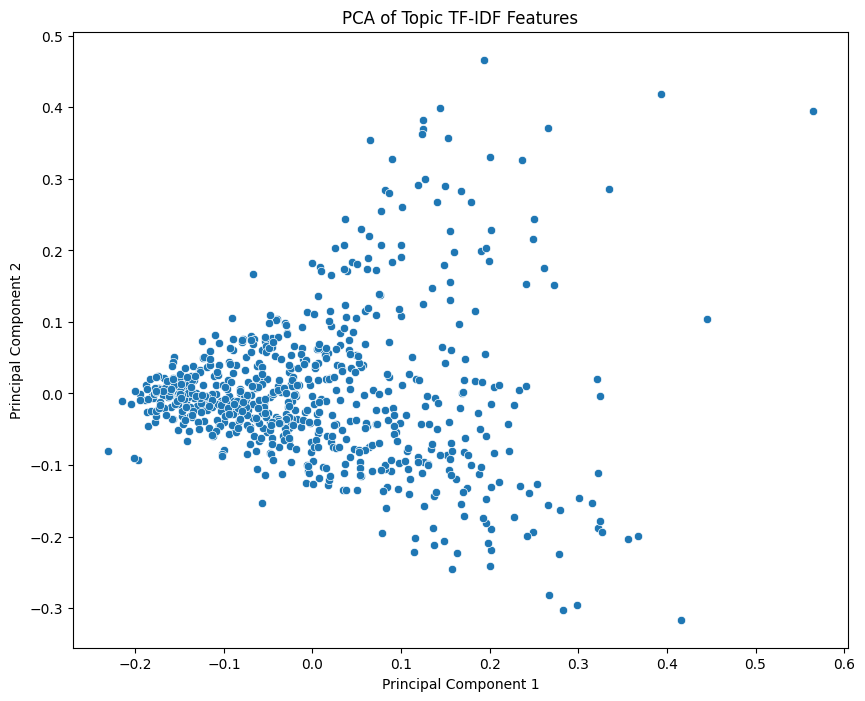

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of the PCA-transformed data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=topic_pca_matrix[:, 0], y=topic_pca_matrix[:, 1])

plt.title('PCA of Topic TF-IDF Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

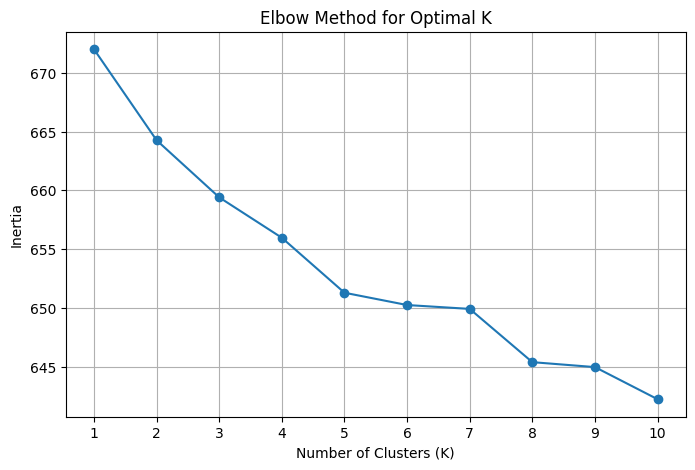

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
# You can adjust the range of n_clusters to test
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Set n_init explicitly
    kmeans.fit(topic_tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [29]:
from sklearn.cluster import KMeans

# Initialize KMeans with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10) # Set n_init explicitly

# Fit the model and predict the cluster labels for each topic
topic_cluster_labels = kmeans.fit_predict(topic_tfidf_matrix)

# Display the cluster labels
print("Cluster labels for each topic:")
print(topic_cluster_labels)

Cluster labels for each topic:
[2 2 4 4 2 4 2 4 2 5 2 4 2 1 2 2 2 2 0 2 4 2 0 2 4 2 2 2 4 2 2 2 4 2 4 4 3
 2 0 0 0 2 2 2 4 2 0 2 2 2 0 2 2 2 4 3 4 2 4 2 4 2 2 2 4 2 2 0 2 2 4 4 5 2
 4 0 2 2 2 2 2 2 2 4 4 0 2 4 2 2 4 2 2 2 4 2 4 2 2 4 2 2 4 2 2 0 2 2 2 2 4
 4 2 4 2 2 2 2 2 4 4 3 2 4 4 4 2 2 2 2 2 2 4 2 2 2 4 2 4 2 4 2 4 2 4 2 4 4
 2 1 2 4 4 4 2 2 2 4 4 4 4 2 4 4 2 2 4 4 2 5 4 4 4 4 5 2 2 2 2 4 2 2 2 4 4
 4 2 0 4 4 2 4 2 2 2 4 2 2 2 4 1 2 4 4 3 4 2 2 2 2 2 4 2 2 2 0 0 4 2 3 4 2
 4 2 0 4 4 2 4 2 4 4 4 4 2 4 4 2 2 0 0 4 4 4 4 2 2 0 2 4 2 2 4 4 2 4 2 0 0
 2 2 2 2 2 2 4 4 2 2 2 4 2 2 0 2 2 4 2 2 4 4 2 2 2 4 0 4 2 4 4 4 2 4 2 4 2
 2 2 5 4 2 4 2 2 2 2 2 2 2 0 4 2 4 0 4 4 2 4 2 4 2 2 2 2 3 4 2 4 2 4 4 2 4
 4 2 2 2 4 2 2 4 2 4 2 4 2 2 2 2 2 4 4 5 2 4 4 2 2 2 4 4 2 2 4 4 4 4 2 2 1
 0 0 4 2 2 2 2 4 0 4 2 4 4 2 4 0 4 2 4 4 2 4 0 4 2 4 4 2 4 4 4 2 2 4 2 2 2
 0 4 2 2 2 2 1 4 4 4 2 2 2 2 2 4 2 2 2 2 4 2 0 2 2 2 2 4 2 4 2 2 5 0 2 2 2
 4 4 4 2 2 4 4 1 4 0 4 2 4 2 2 2 4 0 2 0 2 2 2 4 2 2 2 4 0 2 2 4 4 2 

In [47]:
# Get the cluster centers from the KMeans model
cluster_centers = kmeans.cluster_centers_

# Get the feature names (n-grams) from the TF-IDF vectorizer
feature_names = topic_tfidf_vectorizer.get_feature_names_out()

# Function to get the top n terms for each cluster
def get_top_n_terms(cluster_centers, feature_names, n=10):
    top_terms = {}
    for i, center in enumerate(cluster_centers):
        # Get the indices of the top n terms for the current cluster center
        top_indices = center.argsort()[-n:][::-1]
        # Get the actual terms using the indices
        top_terms[f'Cluster {i}'] = [feature_names[j] for j in top_indices]
    return top_terms

# Get the top 10 terms for each cluster
top_terms_per_cluster = get_top_n_terms(cluster_centers, feature_names, n=40)

# Define a dictionary to map cluster labels to meaningful names based on the top terms
cluster_names = {
    0: 'International Politics',
    1: 'Sözlük Culture',
    2: 'General', # Based on the terms, this cluster seems to be a mix or general topics
    3: 'Domestic Politics',
    4: 'Social/General', # Renamed based on terms like insan, kadın, erkek
    5: 'Football'
}


# Print the top terms for each cluster with their assigned names
for cluster, terms in top_terms_per_cluster.items():
    cluster_label = int(cluster.split(' ')[1])
    print(f"{cluster_names.get(cluster_label, cluster)} ({cluster}): {', '.join(terms)}")

International Politics (Cluster 0): ülke, rusya, abd, türkiye, israil, da, nin, iran, nın, çin, ukrayna, _bkz, de, ın, in, ülkedir, ya, büyük, sonra, suriye, türk, devlet, avrupa, amerika, ülkenin, ancak, olduğu, ye, iyi, ulke, ülkede, almanya, kendi, trump, burada, fransa, yeni, dan, ilk, pakistan
Sözlük Culture (Cluster 1): troll, yazar, entry, _bkz, sözlük, taarruz, gülhan, reklamsız, sözlüğün, ekşi_sözlük, reklam, moderatördür, silişinde, entryler, dalgındır, ananin_oldugu, para, sevelim_sevilelim, farklı_pencerelerden, bakabilsin, ilk, sözlüğe, sözlüğü, zamanın_ötesine, pişmesi, hışım, canlandırıp, buralarda_yeniyim, alamadığından, taarruza, tekin, zam, sözlükte, rabiye, sonra, feci_halde, başlıklar, başlık, ekşi, iyi
General (Cluster 2): _bkz, sonra, iyi, zaman, insan, güzel, ilk, kendi, büyük, öyle, da, in, iki, olabilir, bana, adam, ancak, de, olduğu, şimdi, su, türkiye, başka, yeni, hatta, gün, vardır, aynı, son, şekilde, kadın, içinde, insanlar, önce, oluyor, birde, hala, işt

# Task
Create a line chart showing the number of entries in each cluster (Politics, Sports, Meta, Finance) per year using the `entries` DataFrame and the cluster assignments.

## Map clusters to entries

### Subtask:
Add the cluster labels to the `entries` DataFrame based on the `topic_id`.


**Reasoning**:
Add the cluster labels to the entries DataFrame based on the topic_id by merging the cluster labels with the entries DataFrame.



In [48]:
# Create a DataFrame for cluster labels with corresponding topic_id
topic_clusters_df = pd.DataFrame({
    'topic_id': topic_aggregated_text['topic_id'],
    'cluster_label': topic_cluster_labels
})

# Map the numerical cluster labels to meaningful names
cluster_names = {
    0: 'International Politics',
    1: 'Sözlük Culture',
    2: 'General',
    3: 'Domestic Politics',
    4: 'Social/General',
    5: 'Football'
}
topic_clusters_df['cluster_name'] = topic_clusters_df['cluster_label'].map(cluster_names)


# Merge the cluster labels with the entries DataFrame
entries = pd.merge(entries, topic_clusters_df[['topic_id', 'cluster_name']], on='topic_id', how='left')

# Display the head of the entries DataFrame to verify the new column
display(entries.head())

,entry_id,topic_id,title,author_hash,favorites,created_at_ts,created_at_raw,text_clean,url,text_hash,...,text_processed,title_processed,year_month,hour,tokens,phrased_text_str,cluster_label_x,cluster_label_y,year,cluster_name
0,179182040,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,a9e5be5a0082c6c31a6dc910e3352eac5672d202ef7fa1...,0,2025-10-17 17:26:00,17.10.2025 17:26,https://x.com/…rbandicom/status/19791015344419...,https://eksisozluk.com/3-yildir-evden-cikmayan...,2f60d585b3f53765b6ce9e14cdd6473fdad80fea4d3e61...,...,yuce devletimizin olaya el atmasiyla cozulmus ...,3 yıldır evden çıkmayan gencin evden çıkarılması,2025-10,17.0,"[yuce, devletimizin, olaya, el, atmasiyla, coz...",yuce devletimizin olaya_el atmasiyla cozulmus ...,4,4,2025.0,Social/General
1,179182267,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,3a2f0017065ab43336760c8cecf4986bbaab10efd28209...,0,2025-10-17 17:38:00,17.10.2025 17:38,"benim anladığım, bizler sağlıklı düşünüp tembe...",https://eksisozluk.com/3-yildir-evden-cikmayan...,aea183a5e5191c327ab5fb9aa36f2a93059b615d7be9d2...,...,"anladığım , bizler sağlıklı düşünüp tembellikl...",3 yıldır evden çıkmayan gencin evden çıkarılması,2025-10,17.0,"[anladığım, ,, bizler, sağlıklı, düşünüp, temb...","anladığım , bizler sağlıklı düşünüp tembellikl...",4,4,2025.0,Social/General
2,179182426,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,590c9da2bf0c11b2967d66749188f00d574cbb59208e51...,0,2025-10-17 17:46:00,17.10.2025 17:46,bu genci tedavi etmenin çok basit bir yolu var...,https://eksisozluk.com/3-yildir-evden-cikmayan...,960ace213db65b159822db252a5078a9a8d336ba07dc2d...,...,genci tedavi etmenin basit yolu . kendisini al...,3 yıldır evden çıkmayan gencin evden çıkarılması,2025-10,17.0,"[genci, tedavi, etmenin, basit, yolu, ., kendi...",genci tedavi etmenin basit yolu . kendisini al...,4,4,2025.0,Social/General
3,179182509,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,7c4768cab477b28f3d065b5b47184e821a9bca72b1f937...,0,2025-10-17 17:50:00,17.10.2025 17:50,çocuk derin bir depresyonda ve tek derdi tıraş...,https://eksisozluk.com/3-yildir-evden-cikmayan...,5f66285026d3f4f716591f823867a6fa5f9f9dd673e0a9...,...,çocuk derin depresyonda tek derdi tıraş olmama...,3 yıldır evden çıkmayan gencin evden çıkarılması,2025-10,17.0,"[çocuk, derin, depresyonda, tek, derdi, tıraş,...",çocuk derin depresyonda tek_derdi tıraş olmama...,4,4,2025.0,Social/General
4,179182510,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,0fc0161ae3cf08094f94e92c0ee794abaca1c5030acfd4...,0,2025-10-17 17:50:00,17.10.2025 17:50,allah'tan evden çıkmak istemiyormuş. es kaza s...,https://eksisozluk.com/3-yildir-evden-cikmayan...,60a88c82b18a0297c9dc0c60ba15c83d6ceb79851056d3...,...,allah'tan evden çıkmak istemiyormuş . es kaza ...,3 yıldır evden çıkmayan gencin evden çıkarılması,2025-10,17.0,"[allah'tan, evden, çıkmak, istemiyormuş, ., es...",allah'tan evden_çıkmak istemiyormuş . es_kaza ...,4,4,2025.0,Social/General


## Extract year

### Subtask:
Extract the year from the `created_at_ts` column in the `entries` DataFrame.


**Reasoning**:
Extract the year from the 'created_at_ts' column and add it as a new column named 'year' to the entries DataFrame.



In [49]:
# Extract the year from the 'created_at_ts' column
entries['year'] = entries['created_at_ts'].dt.year

# Display the head of the entries DataFrame to verify the new 'year' column
display(entries[['created_at_ts', 'year']].head())

,created_at_ts,year
0,2025-10-17 17:26:00,2025.0
1,2025-10-17 17:38:00,2025.0
2,2025-10-17 17:46:00,2025.0
3,2025-10-17 17:50:00,2025.0
4,2025-10-17 17:50:00,2025.0


## Group and count

### Subtask:
Group the `entries` DataFrame by year and cluster, and count the number of entries in each group.


**Reasoning**:
Group the entries by year and cluster label and count the number of entries in each group, then reset the index and rename the count column.



**Reasoning**:
The error indicates that the 'cluster_label' column does not exist in the DataFrame. I need to check the column names to find the correct cluster label column and retry the grouping operation.



In [50]:
# Display the columns of the entries DataFrame to check for the correct cluster label column name
display(entries.columns)

Index(['entry_id', 'topic_id', 'title', 'author_hash', 'favorites',
       'created_at_ts', 'created_at_raw', 'text_clean', 'url', 'text_hash',
       'crawl_ts', 'text_processed', 'title_processed', 'year_month', 'hour',
       'tokens', 'phrased_text_str', 'cluster_label_x', 'cluster_label_y',
       'year', 'cluster_name'],
      dtype='object')

**Reasoning**:
The previous output shows that the cluster label column is named 'cluster_label_y'. I will use this correct column name to group the entries by year and cluster label and count the number of entries in each group, then reset the index and rename the count column.



In [62]:
# Group by year and cluster_label_y and count entries
entries_per_year_cluster = entries.groupby(['year', 'cluster_label_y']).size().reset_index(name='entry_count')

## Visualize trends

### Subtask:
Create a line chart to visualize the number of entries for each cluster over time.


**Reasoning**:
Create a line chart to visualize the number of entries for each cluster over time using the grouped data.



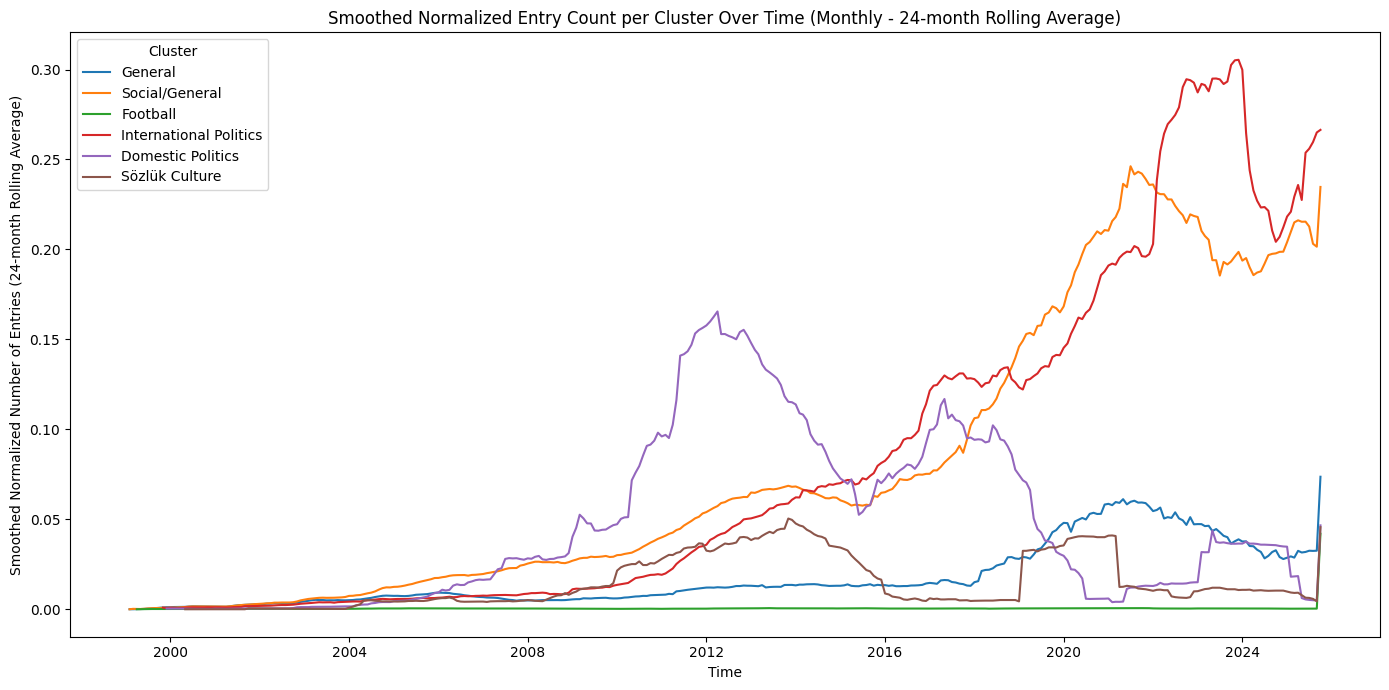

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Group by year_month and cluster_name and count entries for monthly trends
entries_per_month_cluster = entries.groupby(['year_month', 'cluster_name']).size().reset_index(name='entry_count')

# Convert 'year_month' to datetime for plotting
entries_per_month_cluster['year_month'] = entries_per_month_cluster['year_month'].dt.to_timestamp()

# Normalize the entry count for better comparison of trends
# Use MinMaxScaler to scale the entry_count for each cluster between 0 and 1
scaler = MinMaxScaler()
entries_per_month_cluster['entry_count_normalized'] = entries_per_month_cluster.groupby('cluster_name')['entry_count'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# Apply a rolling average to the normalized entry count
# You can adjust the window size (e.g., 3 for 3 months, 6 for 6 months)
window_size = 24
entries_per_month_cluster['entry_count_smooth'] = entries_per_month_cluster.groupby('cluster_name')['entry_count_normalized'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

plt.figure(figsize=(14, 7))

sns.lineplot(data=entries_per_month_cluster, x='year_month', y='entry_count_smooth', hue='cluster_name', palette='tab10') # Changed y to smoothed count


plt.title(f'Smoothed Normalized Entry Count per Cluster Over Time (Monthly - {window_size}-month Rolling Average)')
plt.xlabel('Time') # Updated xlabel
plt.ylabel(f'Smoothed Normalized Number of Entries ({window_size}-month Rolling Average)') # Updated ylabel

plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [71]:
import numpy as np

# [0-9), [9-16), [16-22), [22-24)
bins = [0, 9, 16, 22, 24]

# Labels to match these new bins
labels = [
    'Early Morning (03-08)',
    'Office Hours (09-15)',
    'After-Office (16-21)',
    'Late Night (22-02)'
]

entries['time_of_day'] = pd.cut(entries['hour'], bins=bins, labels=labels, right=True)

display(entries[['hour', 'time_of_day', 'cluster_name']].head())

,hour,time_of_day,cluster_name
0,17.0,After-Office (16-21),Social/General
1,17.0,After-Office (16-21),Social/General
2,17.0,After-Office (16-21),Social/General
3,17.0,After-Office (16-21),Social/General
4,17.0,After-Office (16-21),Social/General


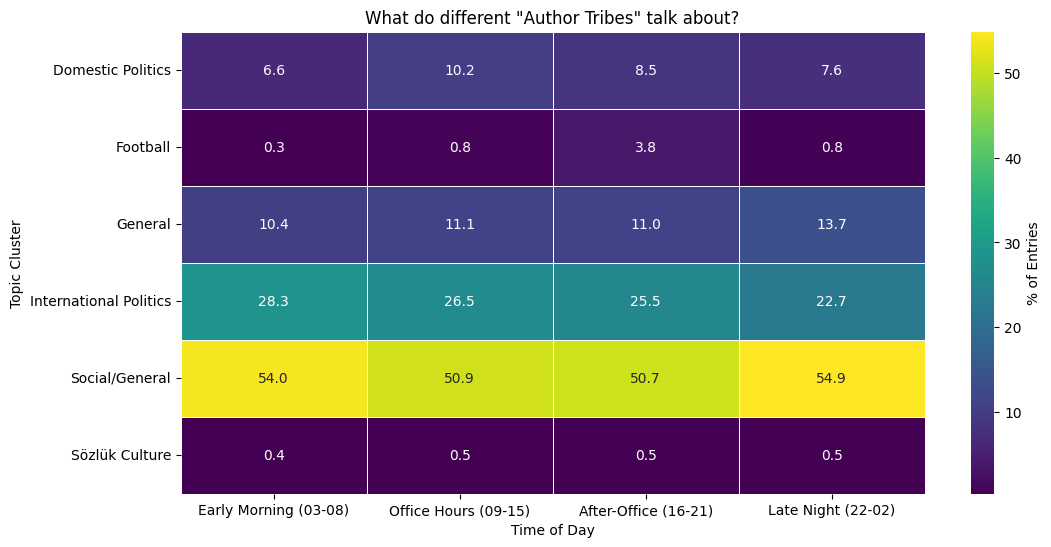

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a crosstab of time_of_day vs. cluster_name
time_cluster_crosstab = pd.crosstab(entries['time_of_day'], entries['cluster_name'])

# Normalize the crosstab by row (so each row sums to 100%)
# This shows the % of conversation for that time block
time_cluster_normalized = time_cluster_crosstab.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    time_cluster_normalized.T,  # Transpose to put time on x-axis
    annot=True,
    fmt=".1f",  # Format as one decimal place
    cmap="viridis",
    linewidths=.5,
    cbar_kws={'label': '% of Entries'}
)
plt.title('What do different "Author Tribes" talk about?')
plt.xlabel('Time of Day')
plt.ylabel('Topic Cluster')
plt.show()

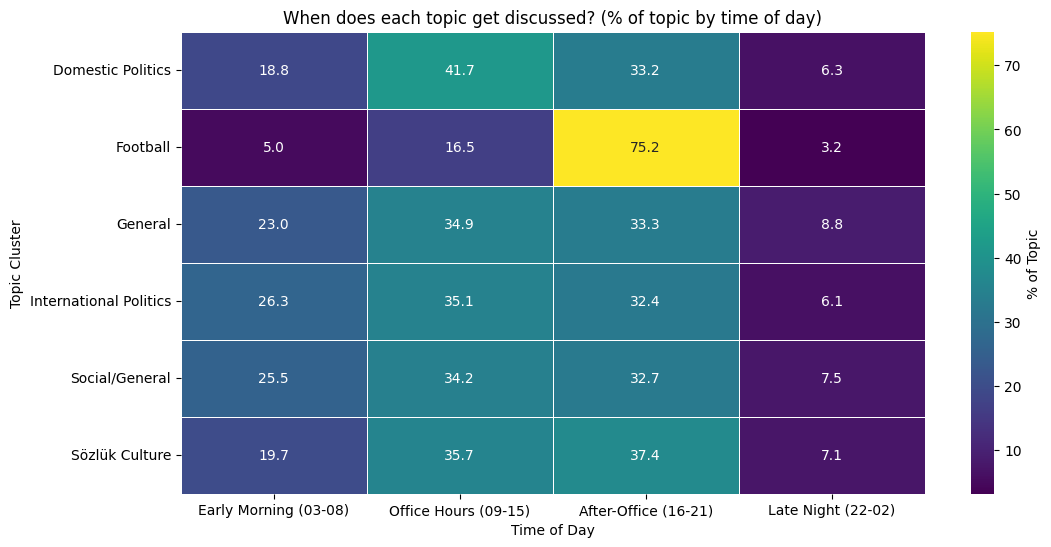

In [73]:
# This is our original crosstab (rows=time, cols=topic)
time_cluster_crosstab = pd.crosstab(entries['time_of_day'], entries['cluster_name'])

# --- THIS IS THE CHANGE ---
# Normalize by column (axis=0), so each TOPIC sums to 100%
time_cluster_normalized_by_topic = time_cluster_crosstab.apply(lambda x: (x / x.sum()) * 100, axis=0)
# -------------------------

# Plot the new heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    time_cluster_normalized_by_topic.T,  # Transpose to put time on x-axis
    annot=True,
    fmt=".1f",
    cmap="viridis",
    linewidths=.5,
    cbar_kws={'label': '% of Topic'} # Updated label
)
plt.title('When does each topic get discussed? (% of topic by time of day)')
plt.xlabel('Time of Day')
plt.ylabel('Topic Cluster')
plt.show()

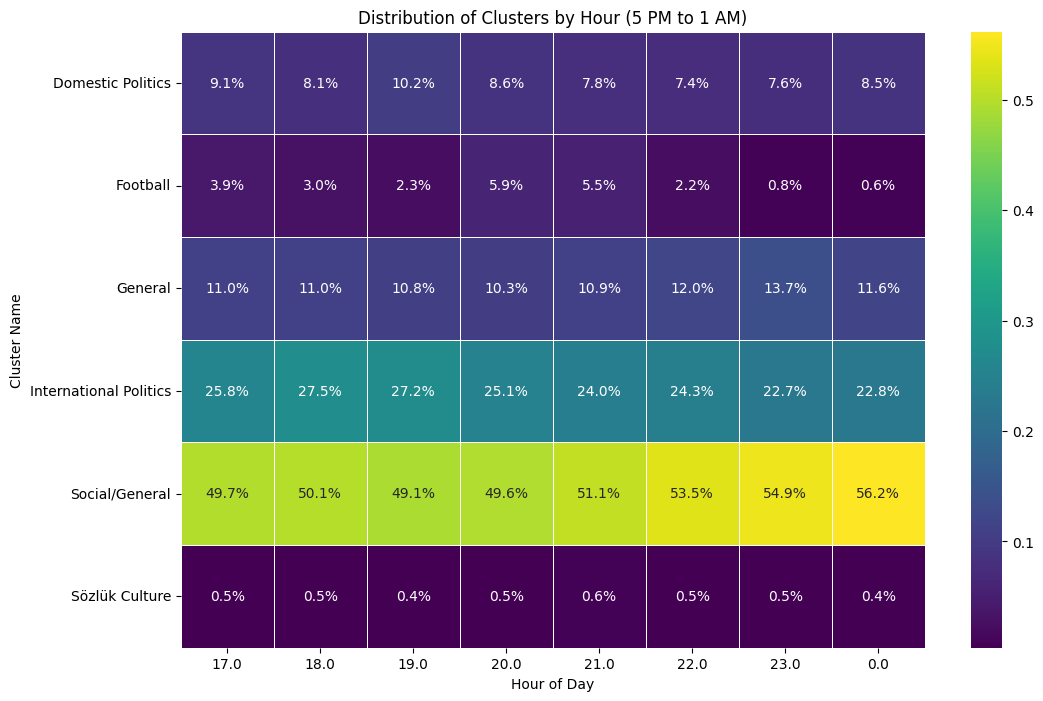

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter entries for hours between 5 PM (17:00) and 1 AM (1:00).
# Need to handle the hour 0 for 1 AM, so we'll include hours 17 through 23 and hour 0.
late_night_entries = entries[(entries['hour'] >= 17) | (entries['hour'] == 0)].copy()


# Group by hour and cluster_name and count entries
hourly_cluster_counts = late_night_entries.groupby(['hour', 'cluster_name']).size().reset_index(name='entry_count')

# Pivot the table to get clusters as rows and hours as columns
pivot_table = hourly_cluster_counts.pivot_table(index='cluster_name', columns='hour', values='entry_count', fill_value=0)

# Reorder columns to have 0 and 1 after 17-23
ordered_columns = sorted(pivot_table.columns.tolist())
# Assuming the hours are 17, 18, 19, 20, 21, 22, 23, 24
ordered_columns = [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 0.0]
pivot_table = pivot_table[ordered_columns]


# Normalize the pivot table by row to show the percentage of each cluster within each hour
# Normalizing by column now to show the percentage of entries in each hour belonging to each cluster
pivot_table_normalized = pivot_table.apply(lambda x: x / x.sum(), axis=0)


# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_normalized, annot=True, fmt=".1%", cmap="viridis", linewidths=.5)

plt.title('Distribution of Clusters by Hour (5 PM to 1 AM)') # Updated title
plt.xlabel('Hour of Day') # Swapped xlabel and ylabel
plt.ylabel('Cluster Name')

plt.show()

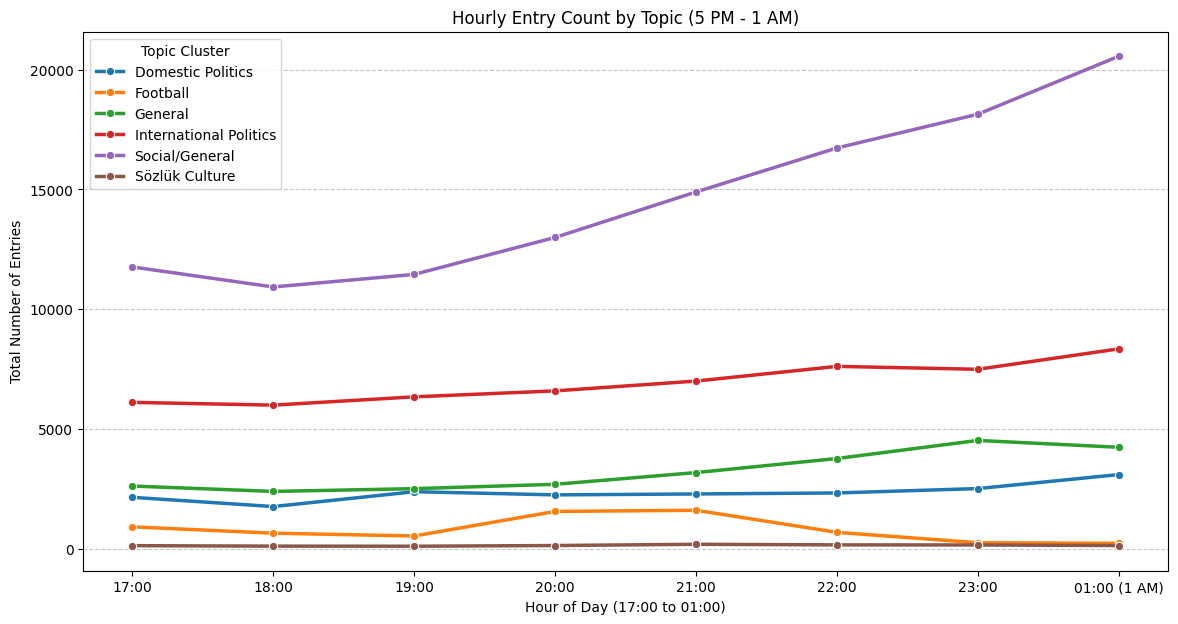

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# You already have 'hourly_cluster_counts' from your last script
# Create a 'plot_hour' column to fix the x-axis ordering (so 0 comes after 23)
hourly_cluster_counts['plot_hour'] = hourly_cluster_counts['hour'].replace(0, 24)

# Now, create a line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=hourly_cluster_counts,
    x='plot_hour',
    y='entry_count',
    hue='cluster_name',
    marker='o',  # Add markers to see the data points
    linewidth=2.5
)

plt.title('Hourly Entry Count by Topic (5 PM - 1 AM)')
plt.xlabel('Hour of Day (17:00 to 01:00)')
plt.ylabel('Total Number of Entries')
# Set custom x-ticks to show the correct hour labels
plt.xticks(
    ticks=[17, 18, 19, 20, 21, 22, 23, 24],
    labels=['17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '01:00 (1 AM)']
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Topic Cluster')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The cluster labels were successfully added to the `entries` DataFrame, using the correct column name 'cluster\_label\_y'.
*   The year was successfully extracted from the `created_at_ts` column and added as a new column named 'year' to the `entries` DataFrame.
*   The data was successfully grouped by year and cluster ('cluster\_label\_y'), and the number of entries for each group was counted and stored in the `entries_per_year_cluster` DataFrame with the count column named 'entry\_count'.
*   A line chart was successfully generated showing the entry count for each cluster over time, with separate lines for each cluster identified by color and a legend.

### Insights or Next Steps

*   Analyze the generated line chart to identify trends in entry counts for each cluster over the years, such as growth, decline, or stability.
*   Consider adding specific cluster names (Politics, Sports, Meta, Finance) to the legend for better interpretability of the line chart.
